In [7]:
import os
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Reshape, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

# Constants
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (*IMAGE_SIZE, 3)
BATCH_SIZE = 126
EPOCHS = 50
LATENT_DIM = 126
KL_WEIGHT = 0.0001

# Paths to dataset directories
BASE_DIR = "../../dataset/balanced/chest_xray"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

In [9]:
# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Only rescaling for validation and test data
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Load training data first to determine class indices
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


Found 4098 images belonging to 3 classes.


In [10]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)

print(f"Detected classes: {class_names}")
print(f"Number of classes: {num_classes}")

Detected classes: ['BACTERIA', 'NORMAL', 'VIRUS']
Number of classes: 3


In [11]:
# load validation and test data with the same class indices
validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


Found 586 images belonging to 3 classes.
Found 1172 images belonging to 3 classes.
Training samples: 4098
Validation samples: 586
Test samples: 1172


In [12]:
# A custom Sampling layer to handle the re parameterization
class Sampling(Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [13]:
# KL Loss Layer
class KLDivergenceLayer(Layer):
    def __init__(self, weight=KL_WEIGHT, **kwargs):
        self.weight = weight
        super(KLDivergenceLayer, self).__init__(**kwargs)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
            axis=-1
        )
        self.add_loss(self.weight * kl_loss)  # Apply weight to KL loss
        return inputs

    def compute_output_shape(self, input_shape):
        return input_shape



In [14]:
# VRNN Model
def vrnn_model(input_shape=INPUT_SHAPE, num_classes=num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # CNN Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # Instead of MaxPooling + Reshape

    # Reshape for RNN
    _, feature_h, feature_w, feature_c = x.shape
    x = Reshape((feature_h, feature_w * feature_c))(x)

    # Bidirectional LSTM (Encoder)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Bidirectional(LSTM(256))(x)

    # Variational Latent Space
    z_mean = Dense(LATENT_DIM*2, name='z_mean')(x)
    z_log_var = Dense(LATENT_DIM*2, name='z_log_var')(x)

    # Apply KL divergence
    KLDivergenceLayer()([z_mean, z_log_var])

    # Use custom Sampling layer
    z = Sampling()([z_mean, z_log_var])

    # Decoder (Dense layers)
    x = Dense(512, activation='relu')(z)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Define VRNN model
    model = Model(inputs, outputs)

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [15]:
# Build and train VRNN
vrnn_model = vrnn_model()
vrnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 112, 112,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 56, 56,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_5[0][0]  

 Total params: 21,997,627 (83.91 MB)

 Trainable params: 21,992,251 (83.89 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [16]:
# Callbacks for training
callbacks = [
    ModelCheckpoint(
        'best_vrnn_chest_xray_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=12,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    )
]

# Train the model
history = vrnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

/Users/davidranamagar/Project/COSC /4337 DataScience II/vibac-pneumonia-detector/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 2/33 ━━━━━━━━━━━━━━━━━━━━ 15:42 30s/step - accuracy: 0.2361 - loss: 1.8254

KeyboardInterrupt: 

In [17]:
# Load the best model
vrnn_model.load_weights('best_vrnn_chest_xray_model.keras')

# Evaluate the model on test data
test_loss, test_accuracy = vrnn_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: 'best_vrnn_chest_xray_model.keras'

In [18]:
# Make predictions on the test set
test_generator.reset()
y_pred = vrnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true classes
y_true = test_generator.classes

# Display classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


 1/10 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step

KeyboardInterrupt: 

In [21]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
plt.close()

NameError: name 'y_true' is not defined

NameError: name 'history' is not defined

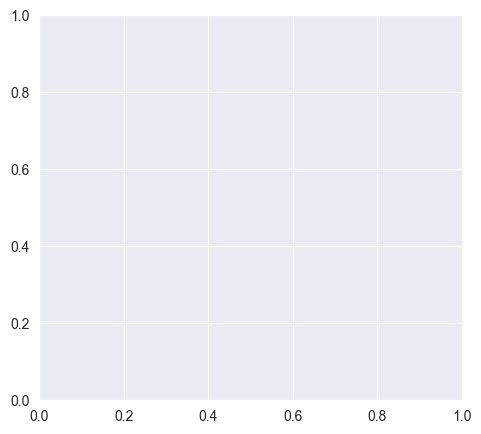

In [22]:
# Plot training history
plt.figure(figsize=(12, 5))
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

NameError: name 'history' is not defined

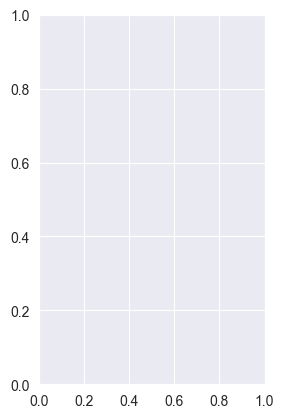

In [23]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [24]:
# Function to predict a single image
def predict_image(image_path, model, class_names):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=IMAGE_SIZE
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Rescale
    img_array = np.expand_dims(img_array, axis=0)  # Create batch

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]

    # Print results
    print(f"Predicted class: {predicted_class}")
    print("Class probabilities:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {predictions[0][i]:.4f}")

    return predicted_class, predictions[0]

In [25]:
# Save the model architecture and weights
vrnn_model.save('vrnn_chest_xray_model.keras')
print("Model saved to 'vrnn_chest_xray_model.keras'")

Model saved to 'vrnn_chest_xray_model.keras'


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


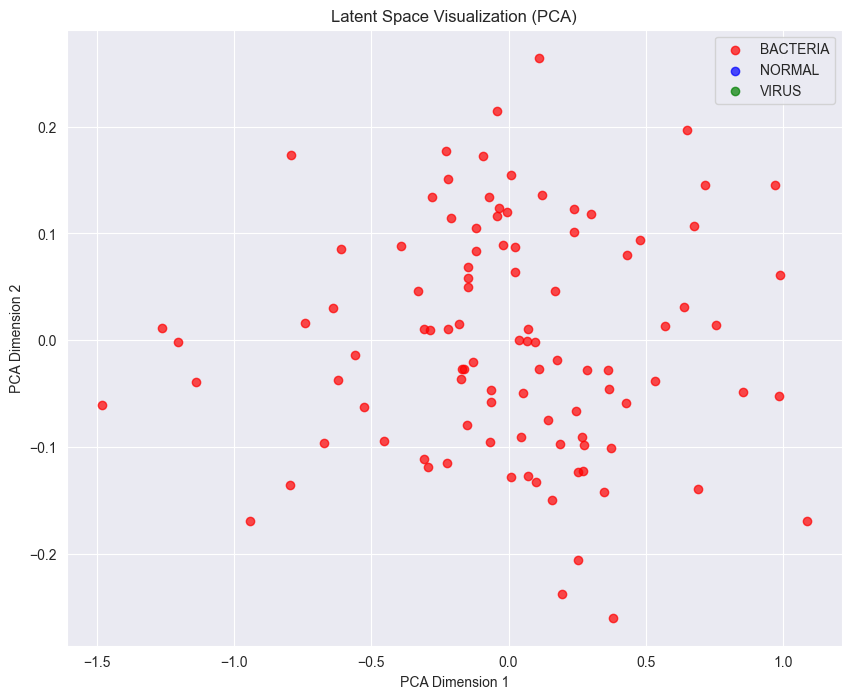

Latent space visualization generated.
